# Plotting with Pandas
The `plot()` method is available on `Series` and `DataFrame` objects. Many of the parameters get passed down to `matplotlib`. The `kind` argument let's us vary the plot type. Here are some commonly used parameters:

| Parameter | Purpose | Data Type |
| --- | --- | --- |
| `kind` | Determines the plot type | String |
| `x`/`y` | Column(s) to plot on the *x*-axis/*y*-axis | String or list |
| `ax` | Draws the plot on the `Axes` object provided | `Axes` |
| `subplots` | Determines whether to make subplots | Boolean |
| `layout` | Specifies how to arrange the subplots | Tuple of `(rows, columns)` |
| `figsize` | Size to make the `Figure` object | Tuple of `(width, height)` | 
| `title` | The title of the plot or subplots | String for the plot title or a list of strings for subplot titles |
| `legend` | Determines whether to show the legend | Boolean |
| `label` | What to call an item in the legend | String if a single column is being plotted; otherwise, a list of strings |
| `style` | `matplotlib` style strings for each item being plotted | String if a single column is being plotted; otherwise, a list of strings |
| `color` | The color to plot the item in | String or red, green, blue tuple if a single column is being plotted; otherwise, a list |
| `colormap` | The colormap to use | String or `matplotlib` colormap object |
| `logx`/`logy`/`loglog` | Determines whether to use a logarithmic scale for the *x*-axis, *y*-axis, or both | Boolean |
| `xticks`/`yticks` | Determines where to draw the ticks on the *x*-axis/*y*-axis | List of values |
| `xlim`/`ylim` | The axis limits for the *x*-axis/*y*-axis | Tuple of the form `(min, max)` |
| `rot` | The angle to write the tick labels at | Integer |
| `sharex`/`sharey` | Determines whether to have subplots share the *x*-axis/*y*-axis | Boolean |
| `fontsize` | Controls the size of the tick labels | Integer |
| `grid` | Turns on/off the grid lines | Boolean |

## About the Data
In this notebook, we will be working with 3 datasets:
- Facebook's stock price throughout 2018 (obtained using the [`stock_analysis` package](https://github.com/stefmolin/stock-analysis))
- Earthquake data from September 18, 2018 - October 13, 2018 (obtained from the US Geological Survey (USGS) using the [USGS API](https://earthquake.usgs.gov/fdsnws/event/1/))
- European Centre for Disease Prevention and Control's (ECDC) [daily number of new reported cases of COVID-19 by country worldwide dataset](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide) collected on September 19, 2020 via [this link](https://opendata.ecdc.europa.eu/covid19/casedistribution/csv)

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fb = pd.read_csv(
    'data/fb_stock_prices_2018.csv', index_col='date', parse_dates=True
)
quakes = pd.read_csv('data/earthquakes.csv')
covid = pd.read_csv('data/covid19_cases.csv').assign(
    date=lambda x: pd.to_datetime(x.dateRep, format='%d/%m/%Y')
).set_index('date').replace(
    'United_States_of_America', 'USA'
).sort_index()['2020-01-18':'2020-09-18']

## Evolution over time
Line plots help us see how a variable changes over time. They are the default for the `kind` argument, but we can pass `kind='line'` to be explicit in our intent:

<AxesSubplot:title={'center':'Evolution of Facebook Open Price'}, xlabel='date'>

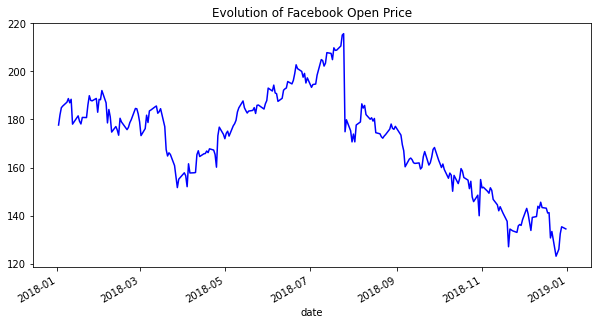

In [2]:
fb.plot(
    kind='line',
    y='open',
    figsize=(10, 5),
    style='-b',
    legend=False,
    title='Evolution of Facebook Open Price'
)

We provided the `style` argument in the previous example; however, we can use the `color` and `linestyle` arguments to get the same result:

<AxesSubplot:title={'center':'Evolution of Facebook Open Price'}, xlabel='date'>

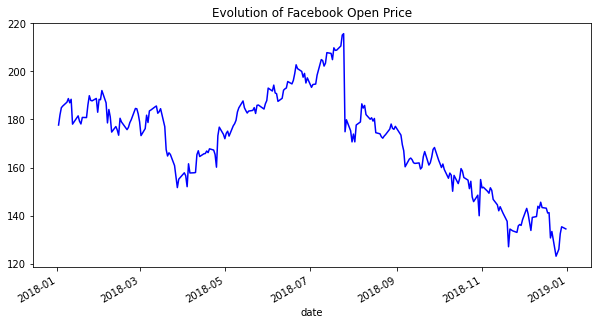

In [3]:
fb.plot(
    kind='line',
    y='open',
    figsize=(10, 5),
    color='blue',
    linestyle='solid',
    legend=False,
    title='Evolution of Facebook Open Price'
)

We can also plot many lines at once by simply passing a list of the columns to plot:

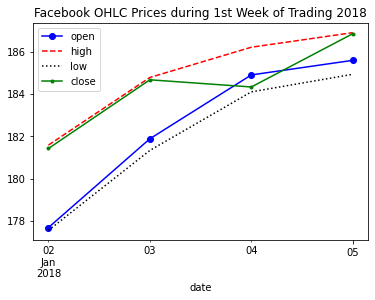

In [4]:
fb.first('1W').plot(
    y=['open', 'high', 'low', 'close'],
    style=['o-b', '--r', ':k', '.-g'],
    title='Facebook OHLC Prices during 1st Week of Trading 2018'
).autoscale()

### Creating subplots
When plotting with `pandas`, creating subplots is simply a matter of passing `subplots=True` to the `plot()` method, and (optionally) specifying the `layout` in a tuple of `(rows, columns)`:

array([[<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>]],
      dtype=object)

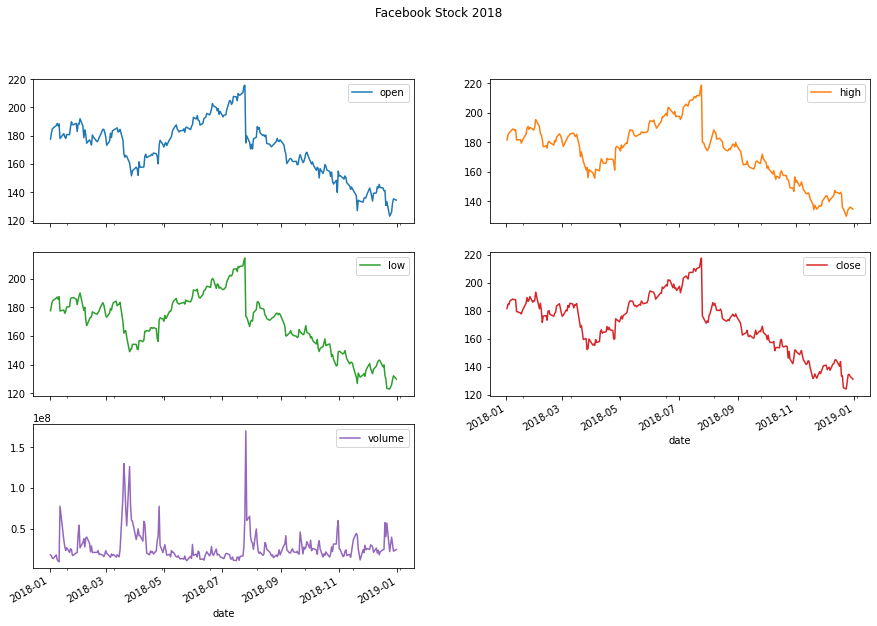

In [5]:
fb.plot(
    kind='line',
    subplots=True,
    layout=(3, 2),
    figsize=(15, 10),
    title='Facebook Stock 2018'
)

Note that we didn't provide a specific column to plot and `pandas` plotted all of them for us.

Sometimes we want to make subplots that each have a few variables in them for comparison. This can be achieved using the `ax` parameter. To illustrate this, let's take a look at daily new COVID-19 cases in China, Spain, Italy, the USA, Brazil, and India:

In [6]:
new_cases_rolling_average = covid.pivot_table(
    index=covid.index, 
    columns='countriesAndTerritories', 
    values='cases'
).rolling(7).mean()

Since there is a lot of fluctuation in these values, we will plot the 7-day moving average of new cases using the `rolling()` method (discussed in chapter 4). Rather than create a separate plot for each country (which makes it harder to compare) or plot them all together (which will make it difficult to see the smaller values), we will plot countries that have had a similar number of cases in the same subplot:

<AxesSubplot:xlabel='date'>

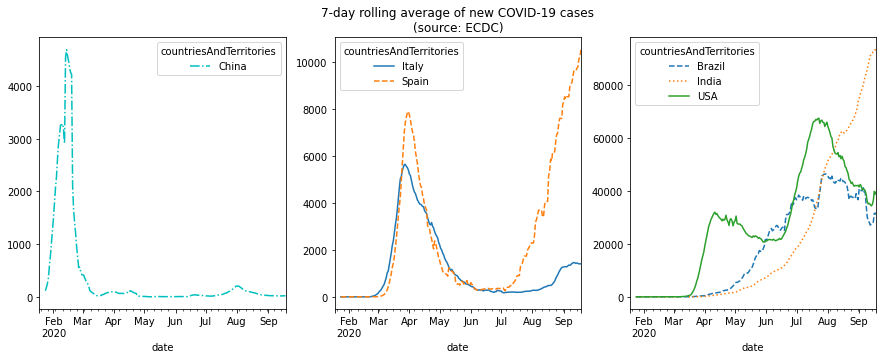

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

new_cases_rolling_average[['China']].plot(ax=axes[0], style='-.c')
new_cases_rolling_average[['Italy', 'Spain']].plot(
    ax=axes[1], style=['-', '--'], 
    title='7-day rolling average of new COVID-19 cases\n(source: ECDC)'
)
new_cases_rolling_average[['Brazil', 'India', 'USA']]\
    .plot(ax=axes[2], style=['--', ':', '-'])

*NOTE: we specified the line styles here so that the lines can be distinguished in the text as a black and white image.*

In the previous figure, we were able to compare countries with similar levels of new COVID-19 cases, but we couldn't compare all of them in the same plot due to scale. One way around this is to use an **area plot**, which makes it possible for us to visualize the overall 7-day rolling average of new COVID-19 cases and at the same time how much each country is contributing to the total. In the interest of readability, we will group Italy and Spain together and create another category for countries other than the USA, Brazil, and India. The combined height of the plot areas is the overall value, and the height of given shaded region is the value for the individual country.

<AxesSubplot:title={'center':'7-day rolling average of new COVID-19 cases\n(source: ECDC)'}, xlabel='date'>

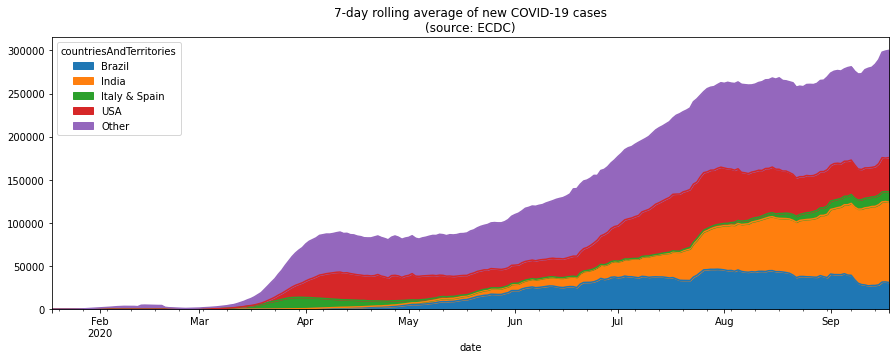

In [8]:
cols = [
    col for col in new_cases_rolling_average.columns 
    if col not in ['USA', 'Brazil', 'India', 'Italy & Spain']
]
new_cases_rolling_average.assign(
    **{'Italy & Spain': lambda x: x.Italy + x.Spain}
).sort_index(axis=1).assign(
    Other=lambda x: x[cols].sum(axis=1)
).drop(columns=cols).plot(
    kind='area', figsize=(15, 5), 
    title='7-day rolling average of new COVID-19 cases\n(source: ECDC)'
)

Another way to visualize evolution over time is to look at the cumulative sum over time. Let's plot the cumulative number of COVID-19 cases in China, Spain, Italy, the USA, Brazil, and India, using `ax` to create subplots as we did in the previous example.

<AxesSubplot:xlabel='date'>

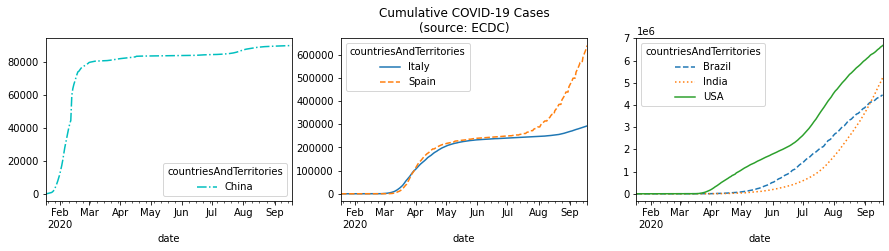

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

cumulative_covid_cases = covid.groupby(
    ['countriesAndTerritories', pd.Grouper(freq='1D')]
).cases.sum().unstack(0).apply('cumsum')

cumulative_covid_cases[['China']].plot(ax=axes[0], style='-.c')
cumulative_covid_cases[['Italy', 'Spain']].plot(
    ax=axes[1], style=['-', '--'], 
    title='Cumulative COVID-19 Cases\n(source: ECDC)'
)
cumulative_covid_cases[['Brazil', 'India', 'USA']]\
    .plot(ax=axes[2], style=['--', ':', '-'])

*NOTE: we specified the line styles here so that the lines can be distinguished in the text as a black and white image.*

## Visualizing relationships between variables
### Scatter plots
We make scatter plots to help visualize the relationship between two variables. Creating scatter plots requires we pass in `kind='scatter'` along with a column for the x-axis and a column for the y-axis:

<AxesSubplot:title={'center':'Facebook Daily High - Low vs. Volume Traded'}, xlabel='volume', ylabel='max_abs_change'>

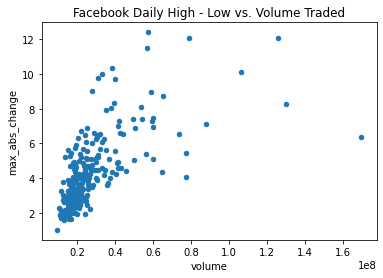

In [10]:
fb.assign(
    max_abs_change=fb.high - fb.low
).plot(
    kind='scatter', x='volume', y='max_abs_change',
    title='Facebook Daily High - Low vs. Volume Traded'
)

The relationship doesn't seem to be linear, but we can try a log transform on the x-axis since the scales of the axes are very different. With `pandas`, we simply pass in `logx=True`:

<AxesSubplot:title={'center':'Facebook Daily High - Low vs. log(Volume Traded)'}, xlabel='volume', ylabel='max_abs_change'>

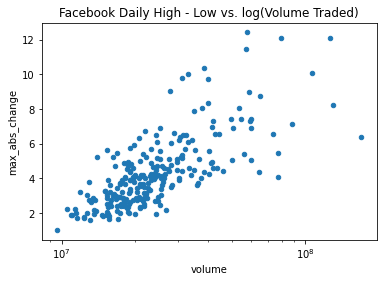

In [11]:
fb.assign(
    max_abs_change=fb.high - fb.low
).plot(
    kind='scatter', x='volume', y='max_abs_change',
    title='Facebook Daily High - Low vs. log(Volume Traded)', 
    logx=True
)

With `matplotlib`, we could use `plt.xscale('log')` to do the same thing.

### Adding Transparency to Plots with `alpha`
Sometimes our plots have many overlapping values, but this can be impossible to see. This can be addressed by increasing the transparency of what we are plotting using the `alpha` parameter. It is a float in the range [0, 1] where 0 is completely transparent and 1 is completely opaque. By default this is 1, so let's put in a lower value and re-plot the scatter plot:

<AxesSubplot:title={'center':'Facebook Daily High - Low vs. log(Volume Traded)'}, xlabel='volume', ylabel='max_abs_change'>

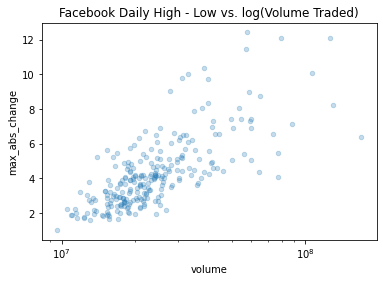

In [12]:
fb.assign(
    max_abs_change=fb.high - fb.low
).plot(
    kind='scatter', x='volume', y='max_abs_change',
    title='Facebook Daily High - Low vs. log(Volume Traded)',
    logx=True, alpha=0.25
)

### Hexbins
In the previous example, we can start to see the overlaps, but it is still difficult. Hexbins are another plot type that divide up the plot into hexagons, which are shaded according to the density of points there. With `pandas`, this is the `hexbin` value for the `kind` argument. It may also be necessary to tweak the `gridsize`, which determines the number of hexagons along the y-axis:

<AxesSubplot:title={'center':'Facebook Daily High - Low vs. log(Volume Traded)'}, xlabel='log_volume', ylabel='max_abs_change'>

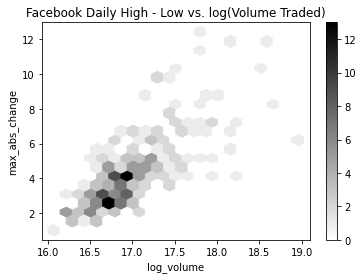

In [13]:
fb.assign(
    log_volume=np.log(fb.volume),
    max_abs_change=fb.high - fb.low
).plot(
    kind='hexbin',
    x='log_volume',
    y='max_abs_change',
    title='Facebook Daily High - Low vs. log(Volume Traded)',
    colormap='gray_r',
    gridsize=20, 
    sharex=False # we have to pass this to see the x-axis
)

### Visualizing Correlations with Heatmaps
Pandas doesn't offer heatmaps; however, if we are able to get our data into a matrix, we can use `matshow()` from matplotlib:

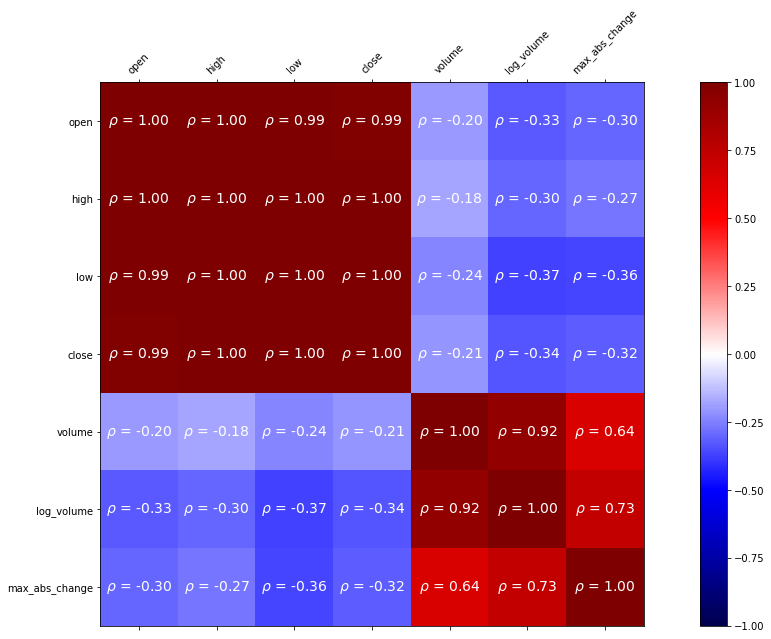

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))

# calculate the correlation matrix
fb_corr = fb.assign(
    log_volume=np.log(fb.volume),
    max_abs_change=fb.high - fb.low
).corr()

# create the heatmap and colorbar
im = ax.matshow(fb_corr, cmap='seismic')
im.set_clim(-1, 1)
fig.colorbar(im)

# label the ticks with the column names
labels = [col.lower() for col in fb_corr.columns]
ax.set_xticks(ax.get_xticks()[1:-1]) # to handle bug in matplotlib
ax.set_xticklabels(labels, rotation=45)
ax.set_yticks(ax.get_yticks()[1:-1]) # to handle bug in matplotlib
ax.set_yticklabels(labels)

# include the value of the correlation coefficient in the boxes
for (i, j), coef in np.ndenumerate(fb_corr):
    ax.text(
        i, j, fr'$\rho$ = {coef:.2f}', # raw (r), format (f) string
        ha='center', va='center', 
        color='white', fontsize=14
    )

Accessing the values in the correlation matrix can be done with `loc[]`:

In [15]:
fb_corr.loc['max_abs_change', ['volume', 'log_volume']]

volume        0.642027
log_volume    0.731542
Name: max_abs_change, dtype: float64

## Visualizing distributions
### Histograms
With the `pandas`, making histograms is as easy as passing `kind='hist'` to the `plot()` method:

Text(0.5, 0, 'Volume traded')

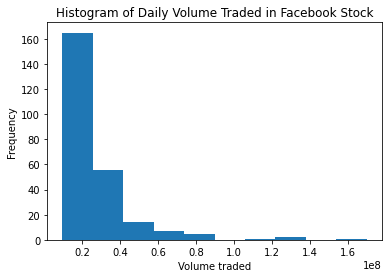

In [16]:
fb.volume.plot(
    kind='hist', 
    title='Histogram of Daily Volume Traded in Facebook Stock'
)
plt.xlabel('Volume traded') # label the x-axis (discussed in chapter 6)

We can overlap histograms to compare distributions provided we use the `alpha` parameter. For example, let's compare the usage and magnitude of the various measurement techniques (the `magType` column) in the data:

Text(0.5, 0, 'magnitude')

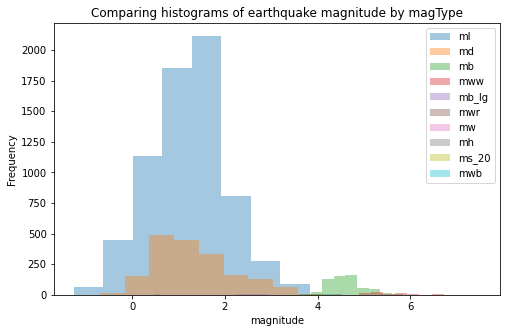

In [17]:
fig, axes = plt.subplots(figsize=(8, 5))

for magtype in quakes.magType.unique():
    data = quakes.query(f'magType == "{magtype}"').mag
    if not data.empty:
        data.plot(
            kind='hist', ax=axes, alpha=0.4, 
            label=magtype, legend=True,
            title='Comparing histograms of earthquake magnitude by magType'
        )

plt.xlabel('magnitude') # label the x-axis (discussed in chapter 6)

### Kernel Density Estimation (KDE)
We can pass `kind='kde'` for an estimate of the probability density function (PDF), which tells us the probability of getting a particular value:

Text(0.5, 0, 'Price ($)')

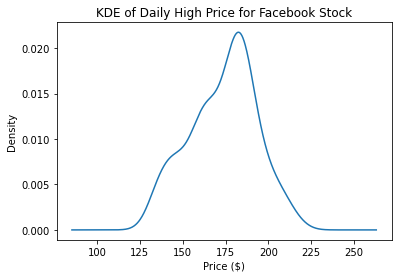

In [18]:
fb.high.plot(
    kind='kde', 
    title='KDE of Daily High Price for Facebook Stock'
)
plt.xlabel('Price ($)') # label the x-axis (discussed in chapter 6)

### Adding to the result of `plot()`
The `plot()` method returns an `Axes` object. We can store this for additional customization of the plot, or we can pass this into another call to `plot()` as the `ax` argument to add to the original plot. 

It can often be helpful to view the KDE superimposed on top of the histogram, which can be achieved with this strategy:

Text(0.5, 0, 'Price ($)')

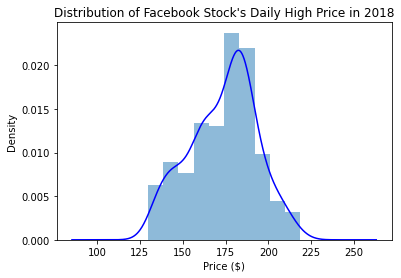

In [19]:
ax = fb.high.plot(kind='hist', density=True, alpha=0.5)
fb.high.plot(
    ax=ax, kind='kde', color='blue', 
    title='Distribution of Facebook Stock\'s Daily High Price in 2018'
)
plt.xlabel('Price ($)') # label the x-axis (discussed in chapter 6)

### Plotting the ECDF
In some cases, we are more interested in the probability of getting less than or equal to that value (or greater than or equal), which we can see with the **cumulative disribution function (CDF)**. Using the `statsmodels` package, we can estimate the CDF giving us the **empirical cumulative distribution function (ECDF)**:

Text(0.5, 1.0, 'ECDF of earthquake magnitude with magType ml')

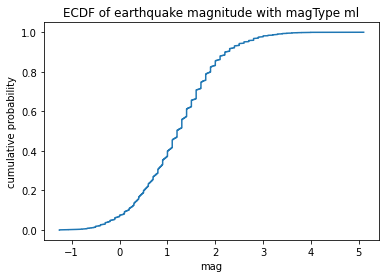

In [20]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(quakes.query('magType == "ml"').mag)
plt.plot(ecdf.x, ecdf.y)

# axis labels (we will cover this in chapter 6)
plt.xlabel('mag') # add x-axis label 
plt.ylabel('cumulative probability') # add y-axis label

# add title (we will cover this in chapter 6)
plt.title('ECDF of earthquake magnitude with magType ml')

This ECDF tells us the probability of getting an earthquake with magnitude of 3 or less using the `ml` scale is 98%:

Text(0.5, 1.0, 'P(mag <= 3) = 98%')

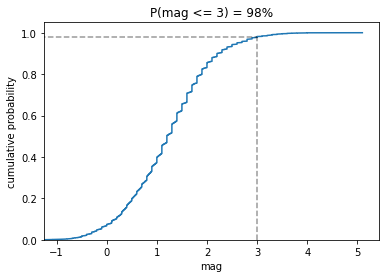

In [21]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(quakes.query('magType == "ml"').mag)
plt.plot(ecdf.x, ecdf.y)

# formatting below will all be covered in chapter 6
# axis labels
plt.xlabel('mag') # add x-axis label 
plt.ylabel('cumulative probability') # add y-axis label

# add reference lines for interpreting the ECDF for mag <= 3 
plt.plot(
    [3, 3], [0, .98], '--k', 
    [-1.5, 3], [0.98, 0.98], '--k', alpha=0.4
)

# set axis ranges
plt.ylim(0, None)
plt.xlim(-1.25, None)

# add a title
plt.title('P(mag <= 3) = 98%')

### Box plots
To make box plots with `pandas`, we pass `kind='box'` to the `plot()` method:

Text(0, 0.5, 'price ($)')

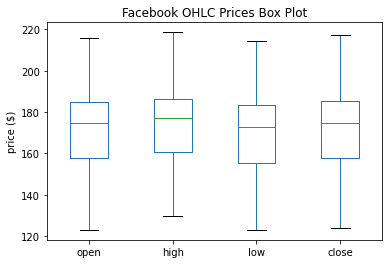

In [22]:
fb.iloc[:,:4].plot(kind='box', title='Facebook OHLC Prices Box Plot')
plt.ylabel('price ($)') # label the x-axis (discussed in chapter 6)

If we pass in `notch=True`, we get a notched box plot. The notch represents a 95% confidence interval around the median, which can be helpful when comparing differences. For an introduction to interpreting a notched box plot, see this [Google sites page](https://sites.google.com/site/davidsstatistics/home/notched-box-plots) and this [Towards Data Science article](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51).

Text(0, 0.5, 'price ($)')

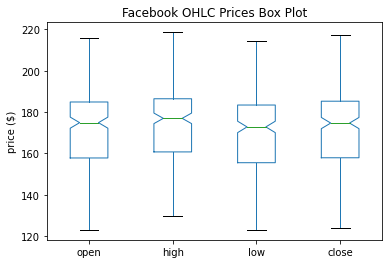

In [23]:
fb.iloc[:,:4].plot(kind='box', title='Facebook OHLC Prices Box Plot', notch=True)
plt.ylabel('price ($)') # label the x-axis (discussed in chapter 6)

This can also be combined with a call to `groupby()`:

Text(0.5, 1.1, 'Facebook OHLC Box Plots by Volume Traded')

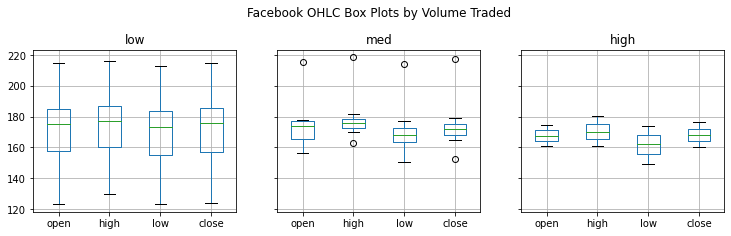

In [24]:
fb.assign(
    volume_bin=pd.cut(fb.volume, 3, labels=['low', 'med', 'high'])
).groupby('volume_bin').boxplot(
    column=['open', 'high', 'low', 'close'],
    layout=(1, 3), figsize=(12, 3)
)
plt.suptitle('Facebook OHLC Box Plots by Volume Traded', y=1.1)

We can use this to see the distribution of magnitudes across the different measurement methods for earthquakes:

Text(0, 0.5, 'magnitude')

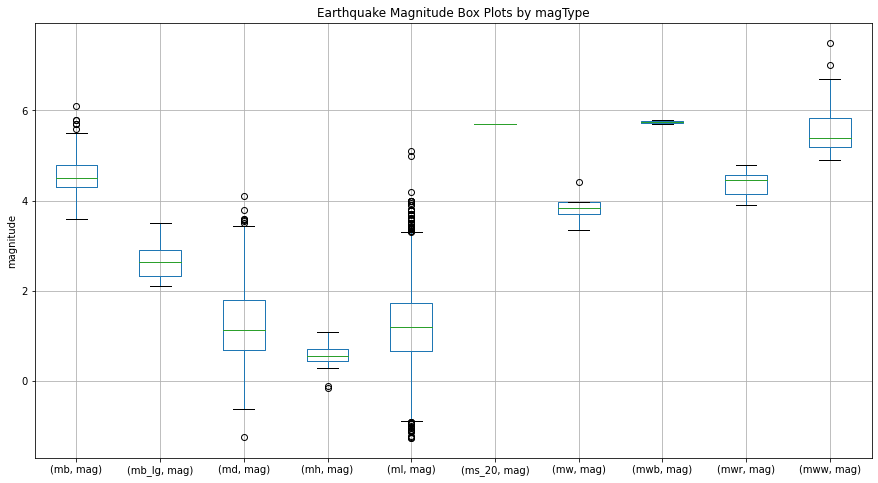

In [25]:
quakes[['mag', 'magType']].groupby('magType').boxplot(
    figsize=(15, 8), subplots=False
)
plt.title('Earthquake Magnitude Box Plots by magType')
plt.ylabel('magnitude') # label the y-axis (discussed in chapter 6)

## Counts and frequencies
### Bar charts
Passing `kind='barh'` gives us horizontal bars while `kind='bar'` gives us vertical ones. Let's use horizontal bars to look at the top 15 places for earthquakes in our data:

Text(0.5, 0, 'earthquakes')

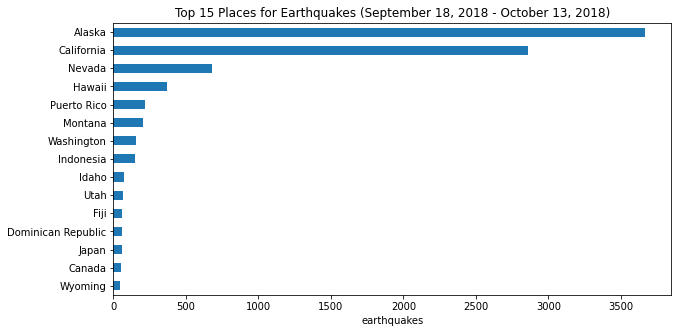

In [26]:
quakes.parsed_place.value_counts().iloc[14::-1,].plot(
    kind='barh', figsize=(10, 5),
    title='Top 15 Places for Earthquakes '
          '(September 18, 2018 - October 13, 2018)'
)
plt.xlabel('earthquakes') # label the x-axis (discussed in chapter 6)

We also have data on whether earthquakes were accompanied by tsunamis. Let's see what the top places for tsunamis are:

Text(0.5, 0, 'tsunamis')

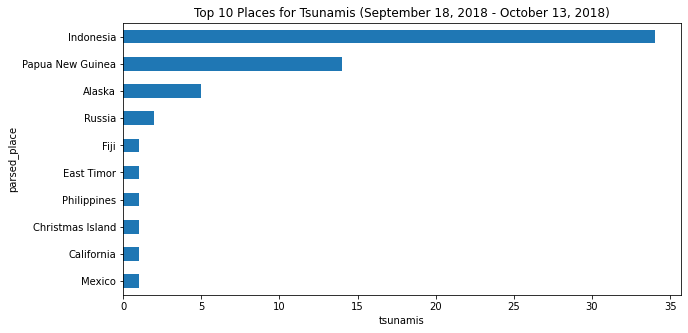

In [27]:
quakes.groupby('parsed_place').tsunami.sum().sort_values().iloc[-10:,].plot(
    kind='barh', figsize=(10, 5), 
    title='Top 10 Places for Tsunamis '
          '(September 18, 2018 - October 13, 2018)'
)
plt.xlabel('tsunamis') # label the x-axis (discussed in chapter 6)

Seeing that Indonesia is the top place for tsunamis during the time period we are looking at, we may want to look how many earthquakes and tsunamis Indonesia gets on a daily basis. We could show this as a line plot or with bars; since we don't want to interpolate, we will use bars here:

Text(0, 0.5, 'count')

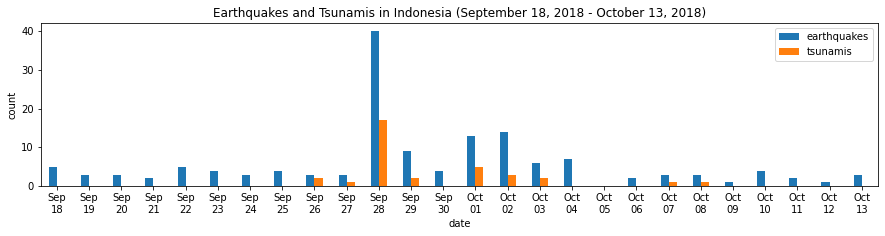

In [28]:
indonesia_quakes = quakes.query('parsed_place == "Indonesia"').assign(
    time=lambda x: pd.to_datetime(x.time, unit='ms'),
    earthquake=1
).set_index('time').resample('1D').sum()

# format the datetimes in the index for the x-axis
indonesia_quakes.index = indonesia_quakes.index.strftime('%b\n%d')

indonesia_quakes.plot(
    y=['earthquake', 'tsunami'], kind='bar', figsize=(15, 3), 
    rot=0, label=['earthquakes', 'tsunamis'], 
    title='Earthquakes and Tsunamis in Indonesia '
          '(September 18, 2018 - October 13, 2018)'
)

# label the axes (discussed in chapter 6)
plt.xlabel('date')
plt.ylabel('count')

### Grouped Bars

Text(0, 0.5, '')

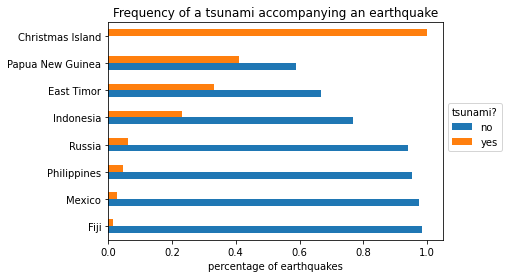

In [29]:
quakes.groupby(['parsed_place', 'tsunami']).mag.count()\
    .unstack().apply(lambda x: x / x.sum(), axis=1)\
    .rename(columns={0: 'no', 1: 'yes'})\
    .sort_values('yes', ascending=False)[7::-1]\
    .plot.barh(
        title='Frequency of a tsunami accompanying an earthquake'
    )

# move legend to the right of the plot
plt.legend(title='tsunami?', bbox_to_anchor=(1, 0.65))

# label the axes (discussed in chapter 6)
plt.xlabel('percentage of earthquakes')
plt.ylabel('')

Using the `kind` arugment for vertical bars when the labels for each bar are shorter:

Text(0, 0.5, 'earthquakes')

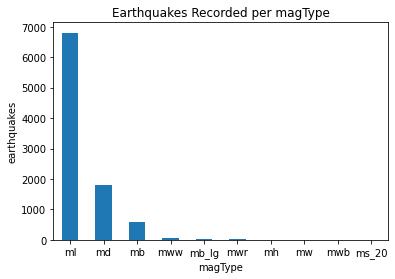

In [30]:
quakes.magType.value_counts().plot(
    kind='bar', title='Earthquakes Recorded per magType', rot=0
)

# label the axes (discussed in chapter 6)
plt.xlabel('magType')
plt.ylabel('earthquakes')

### Stacked bars

<AxesSubplot:title={'center':'Earthquakes by integer magnitude and magType'}, xlabel='mag_bin', ylabel='earthquakes'>

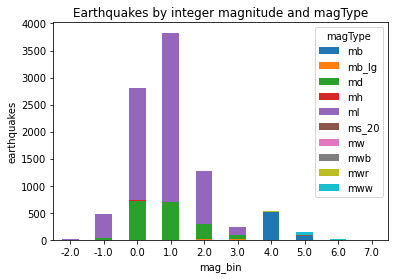

In [31]:
pivot = quakes.assign(
    mag_bin=lambda x: np.floor(x.mag)
).pivot_table(
    index='mag_bin', columns='magType', values='mag', aggfunc='count'
)
pivot.plot.bar(
    stacked=True, rot=0, ylabel='earthquakes', 
    title='Earthquakes by integer magnitude and magType'
)

#### Normalized stacked bars
Plot the percentages to be better able to see the different `magTypes`.

Text(0, 0.5, 'percentage')

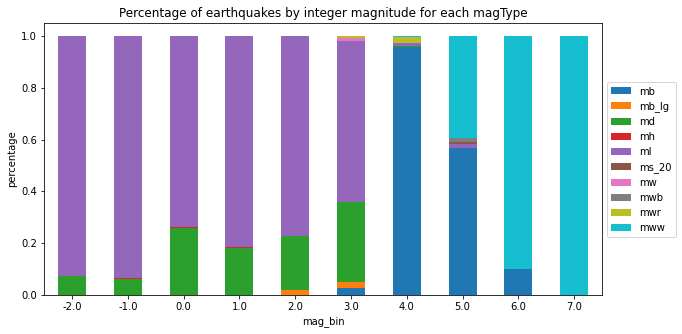

In [32]:
normalized_pivot = pivot.fillna(0).apply(lambda x: x / x.sum(), axis=1)
ax = normalized_pivot.plot.bar(
    stacked=True, rot=0, figsize=(10, 5),
    title='Percentage of earthquakes by integer magnitude for each magType'
)
ax.legend(bbox_to_anchor=(1, 0.8)) # move legend to the right of the plot
plt.ylabel('percentage') # label the axes (discussed in chapter 6)

We can also create horizontal stacked bars and do so using `groupby()` and `unstack()`:

Text(0, 0.5, '')

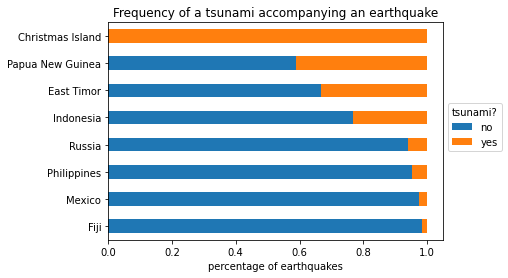

In [33]:
quakes.groupby(['parsed_place', 'tsunami']).mag.count()\
    .unstack().apply(lambda x: x / x.sum(), axis=1)\
    .rename(columns={0: 'no', 1: 'yes'})\
    .sort_values('yes', ascending=False)[7::-1]\
    .plot.barh(
        title='Frequency of a tsunami accompanying an earthquake', 
        stacked=True
    )

# move legend to the right of the plot
plt.legend(title='tsunami?', bbox_to_anchor=(1, 0.65))

# label the axes (discussed in chapter 6)
plt.xlabel('percentage of earthquakes')
plt.ylabel('')

<hr>
<div>
    <a href="./1-introducing_matplotlib.ipynb">
        <button>&#8592; Previous Notebook</button>
    </a>
    <a href="./3-pandas_plotting_module.ipynb">
        <button style="float: right;">Next Notebook &#8594;</button>
    </a>
</div>
<hr>